# Pedro de Figueiredo Abissamra

## Rede LSTM Proposta

In [ ]:
#Bibliotecas de processamento de sinal
import scipy.io as io
from scipy import signal
import numpy as np
import h5py
import math
import matplotlib.pyplot as plt
import random
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import time

#Biblioteca de aprendizado de máquina
import tensorflow as tf
from tensorflow import keras
from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Embedding
from keras.preprocessing import sequence
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tensorflow.keras.callbacks import ModelCheckpoint
from keras.callbacks import Callback

In [2]:
# Verifica se existe GPU disponível
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

# Verifica detalhes da GPU, se disponível
if len(tf.config.experimental.list_physical_devices('GPU')) > 0:
    print("Using GPU:", tf.config.experimental.list_physical_devices('GPU')[0])
else:
    print("No GPU detected, using CPU")


Num GPUs Available:  1
Using GPU: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [3]:
# Limita o crescimento da memória da GPU
physical_devices = tf.config.list_physical_devices('GPU')
for device in physical_devices:
    tf.config.experimental.set_memory_growth(device, True)

In [4]:
# Caminho do dataset
dataset_path = "C:\\Users\\abiss\\Desktop\\Pedro\\"

In [5]:
# Impotação dos dados de entrada
with h5py.File(dataset_path +'X_train.mat', 'r') as f:
    X_train = np.array(f['X_train'], dtype='float32').T
with h5py.File(dataset_path +'X_val.mat', 'r') as f:
   X_val = np.array(f['X_val'], dtype='float32').T
with h5py.File(dataset_path +'X_test.mat', 'r') as f:
    X_test = np.array(f['X_test'], dtype='float32').T

In [6]:
# Importação dos dados de saída e labels
Y_train = io.loadmat(dataset_path + 'Y_train.mat')['Y_train']
Y_val = io.loadmat(dataset_path + 'Y_val.mat')['Y_val']
Y_test = io.loadmat(dataset_path + 'Y_test.mat')['Y_test']
lbl_train = io.loadmat(dataset_path + 'lbl_train.mat')['lbl_train']
lbl_val = io.loadmat(dataset_path + 'lbl_val.mat')['lbl_val']
lbl_test = io.loadmat(dataset_path + 'lbl_test.mat')['lbl_test']

In [7]:
# Verificação do formato dos dados de entrada
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

# Verificação do formato dos dados de saída
print(Y_train.shape)
print(Y_test.shape)
print(Y_val.shape)

# Verificação do formato das labels
print(lbl_train.shape)
print(lbl_test.shape)
print(lbl_val.shape)

(469200, 1024, 2)
(156400, 1024, 2)
(156400, 1024, 2)
(469200, 23)
(156400, 23)
(156400, 23)
(469200, 6)
(156400, 6)
(156400, 6)


In [8]:
# Contagem da quantidade de amostras para cada um dos tipos de modulação para o dataset completo
count = np.zeros(24)
for i in range (len(Y_train)-1):
    count[int(lbl_train[i,0])] += 1
print(count)

count = np.zeros(24)
for i in range (len(Y_test)-1):
    count[int(lbl_test[i,0])] += 1
print(count)

count = np.zeros(24)
for i in range (len(Y_val)-1):
    count[int(lbl_val[i,0])] += 1
print(count)

[    0. 20400. 20400. 20400. 20400. 20400. 20400. 20400. 20400. 20400.
 20400. 20400. 20400. 20400. 20400. 20400. 20400. 20400. 20400. 20400.
 20400. 20400. 20400. 20399.]
[   0. 6800. 6800. 6800. 6800. 6800. 6800. 6800. 6800. 6800. 6800. 6800.
 6800. 6800. 6800. 6800. 6800. 6800. 6800. 6800. 6800. 6800. 6800. 6799.]
[   0. 6800. 6800. 6800. 6800. 6800. 6800. 6800. 6800. 6800. 6800. 6800.
 6800. 6800. 6800. 6800. 6800. 6800. 6800. 6800. 6800. 6800. 6800. 6799.]


In [9]:
# Seleção das modulações desejadas do dataset
desired_vals = [0, 4, 5, 8, 10, 11, 12, 13, 14, 21, 22]

# Vetores para particionamento das amostras de treino
slices_X_train = []
slices_Y_train = []
slices_lbl_train = []

# Criação dos novos dados de treinamento
for i in range(len(desired_vals)):
    slice_start = desired_vals[i] * 20400
    slice_end = (desired_vals[i] * 20400)+20400
    slices_X_train.append(X_train[slice_start:slice_end])
    slices_Y_train.append(Y_train[slice_start:slice_end])
    slices_lbl_train.append(lbl_train[slice_start:slice_end])

new_X_train = np.concatenate(slices_X_train, axis=0)
new_Y_train = np.concatenate(slices_Y_train, axis=0)
new_Y_train = new_Y_train[:, desired_vals]
new_lbl_train = np.concatenate(slices_lbl_train, axis=0)

# Verificação do formato dos novos dados de treinamento
print("New X_train shape:", new_X_train.shape)
print("New Y_train shape:", new_Y_train.shape)
print("New lbl_train shape:", new_lbl_train.shape)

# Vetores para particionamento das amostras de teste
slices_X_test = []
slices_Y_test = []
slices_lbl_test = []

# Criação dos novos dados de teste
for i in range(len(desired_vals)):
    slice_start = desired_vals[i] * 6800
    slice_end = (desired_vals[i] * 6800)+6800
    slices_X_test.append(X_test[slice_start:slice_end])
    slices_Y_test.append(Y_test[slice_start:slice_end])
    slices_lbl_test.append(lbl_test[slice_start:slice_end])

new_X_test = np.concatenate(slices_X_test, axis=0)
new_Y_test = np.concatenate(slices_Y_test, axis=0)
new_Y_test = new_Y_test[:, desired_vals]
new_lbl_test = np.concatenate(slices_lbl_test, axis=0)

# Verificação do formato dos novos dados de teste
print("New X_test shape:", new_X_test.shape)
print("New Y_test shape:", new_Y_test.shape)
print("New lbl_test shape:", new_lbl_test.shape)

# Vetores para particionamento das amostras de validação
slices_X_val = []
slices_Y_val = []
slices_lbl_val = []

# Criação dos novos dados de validação
for i in range(len(desired_vals)):
    slice_start = desired_vals[i] * 6800
    slice_end = (desired_vals[i] * 6800)+6800
    slices_X_val.append(X_val[slice_start:slice_end])
    slices_Y_val.append(Y_val[slice_start:slice_end])
    slices_lbl_val.append(lbl_val[slice_start:slice_end])

new_X_val = np.concatenate(slices_X_val, axis=0)
new_Y_val = np.concatenate(slices_Y_val, axis=0)
new_Y_val = new_Y_val[:, desired_vals]
new_lbl_val = np.concatenate(slices_lbl_val, axis=0)

# Verificação do formato dos novos dados de validação
print("New X_val shape:", new_X_val.shape)
print("New Y_val shape:", new_Y_val.shape)
print("New lbl_val shape:", new_lbl_val.shape)

New X_train shape: (224400, 1024, 2)
New Y_train shape: (224400, 11)
New lbl_train shape: (224400, 6)
New X_test shape: (74800, 1024, 2)
New Y_test shape: (74800, 11)
New lbl_test shape: (74800, 6)
New X_val shape: (74800, 1024, 2)
New Y_val shape: (74800, 11)
New lbl_val shape: (74800, 6)


In [10]:
# Contagem da quantidade de amostras para cada um dos tipos de modulação para o dataset reduzido
count = np.zeros(24)
for i in range (len(new_Y_train)-1):
    count[int(new_lbl_train[i,0])] += 1
print(count)

count = np.zeros(24)
for i in range (len(new_Y_test)-1):
    count[int(new_lbl_test[i,0])] += 1
print(count)

count = np.zeros(24)
for i in range (len(new_Y_val)-1):
    count[int(new_lbl_val[i,0])] += 1
print(count)

[    0. 20400.     0.     0.     0. 20400. 20400.     0.     0. 20400.
     0. 20400. 20400. 20400. 20400. 20400.     0.     0.     0.     0.
     0.     0. 20400. 20399.]
[   0. 6800.    0.    0.    0. 6800. 6800.    0.    0. 6800.    0. 6800.
 6800. 6800. 6800. 6800.    0.    0.    0.    0.    0.    0. 6800. 6799.]
[   0. 6800.    0.    0.    0. 6800. 6800.    0.    0. 6800.    0. 6800.
 6800. 6800. 6800. 6800.    0.    0.    0.    0.    0.    0. 6800. 6799.]


In [ ]:
# Criando o modelo LSTM
model = Sequential()
model.add(LSTM(units=64,input_shape=(1024, 2),return_sequences=True))
model.add(LSTM(units=64,return_sequences=True))
model.add(LSTM(units=64,return_sequences=True))
model.add(LSTM(units=64))
model.add(Dense(len(desired_vals),activation = 'softmax'))
model.summary()

# Compilação do modelo gerado
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1024, 64)          17152     
                                                                 
 lstm_1 (LSTM)               (None, 1024, 64)          33024     
                                                                 
 lstm_2 (LSTM)               (None, 1024, 64)          33024     
                                                                 
 lstm_3 (LSTM)               (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 11)                715       
                                                                 
Total params: 116,939
Trainable params: 116,939
Non-trainable params: 0
_________________________________________________________________


In [12]:
# Criação da classe de learning rate cíclico
class CyclicLR(Callback):
    def __init__(self, base_lr, max_lr, step_size, mode='triangular'):
        super(CyclicLR, self).__init__()
        self.base_lr = base_lr
        self.max_lr = max_lr
        self.step_size = step_size
        self.mode = mode
        self.iteration = 0
        self.history = {}

    def on_batch_end(self, batch, logs=None):
        self.iteration += 1
        cycle = np.floor(1 + self.iteration / (2 * self.step_size))
        x = np.abs(self.iteration / self.step_size - 2 * cycle + 1)
        if self.mode == 'triangular':
            lr = self.base_lr + (self.max_lr - self.base_lr) * max(0, (1 - x))
        else:
            raise ValueError("Unknown mode")
        
        self.model.optimizer.lr = lr
        self.history[self.iteration] = lr

In [13]:
# Configuração do checkpoint para salvar melhor modelo obtido
checkpoint = ModelCheckpoint(
    filepath="best_model_teste_2.h5",       
    monitor="val_accuracy",             
    save_best_only=True,          
    mode="max",                    
    verbose=1                      
)

Epoch 1/500
439/439 [==============================] - ETA: 0s - loss: 2.1577 - accuracy: 0.1810
Epoch 1: val_accuracy improved from -inf to 0.20691, saving model to best_model_teste_2.h5
439/439 [==============================] - 172s 377ms/step - loss: 2.1577 - accuracy: 0.1810 - val_loss: 1.9936 - val_accuracy: 0.2069
Epoch 2/500
439/439 [==============================] - ETA: 0s - loss: 2.0577 - accuracy: 0.2191
Epoch 2: val_accuracy did not improve from 0.20691
439/439 [==============================] - 163s 371ms/step - loss: 2.0577 - accuracy: 0.2191 - val_loss: 2.3672 - val_accuracy: 0.1070
Epoch 3/500
439/439 [==============================] - ETA: 0s - loss: 2.3011 - accuracy: 0.1385
Epoch 3: val_accuracy did not improve from 0.20691
439/439 [==============================] - 163s 371ms/step - loss: 2.3011 - accuracy: 0.1385 - val_loss: 2.3476 - val_accuracy: 0.1097
Epoch 4/500
439/439 [==============================] - ETA: 0s - loss: 2.1835 - accuracy: 0.1705
Epoch 4: val_a

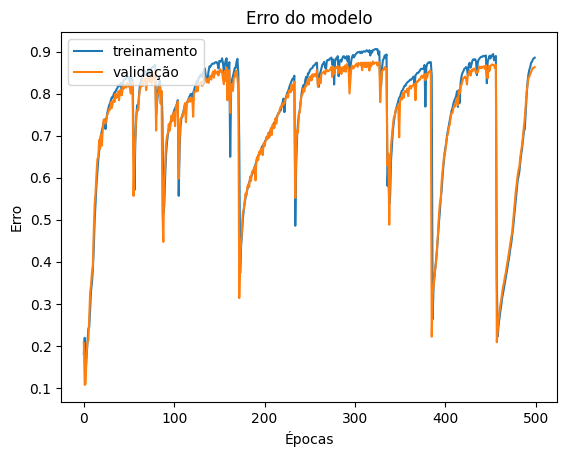

In [ ]:
# Definição dos valores do lr cíclico
clr = CyclicLR(base_lr=1e-7, max_lr=1e-3, step_size=50)

# Treinamento do modelo
history = model.fit(
    new_X_train,
    new_Y_train,
    epochs=500,
    batch_size=512,
    validation_data=(new_X_val, new_Y_val),
    callbacks=[clr, checkpoint],
    shuffle=True
)

# Plot da acurácia dos dados de treinamento e validação
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Erro do modelo') #Obs: É acurácia, não erro!!!
plt.ylabel('Erro') #Obs: É acurácia, não erro!!!
plt.xlabel('Épocas')
plt.legend(['treinamento', 'validação'], loc='upper left')
plt.show()

In [11]:
# Carrega melhor modelo obtido
model = tf.keras.models.load_model('best_model_teste_2.h5')

C:\Users\abiss\AppData\Local\Temp\ipykernel_1348\1725456917.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab20', num_modulations)


138/138 [==============================] - 12s 84ms/step


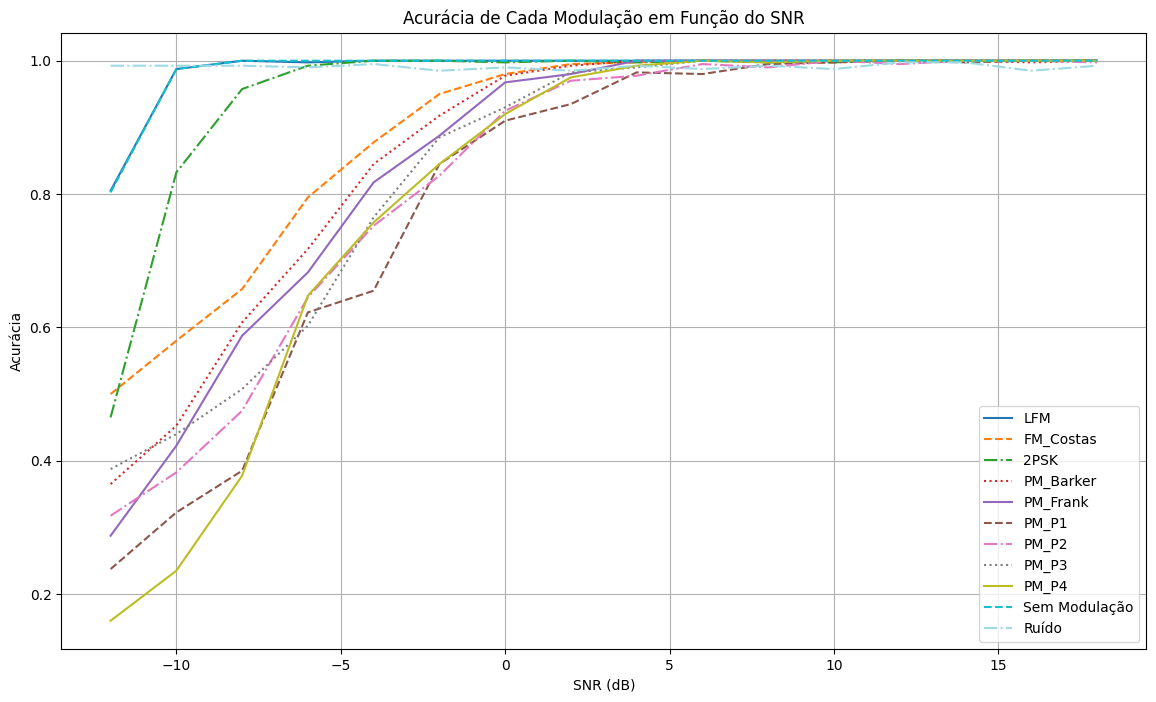

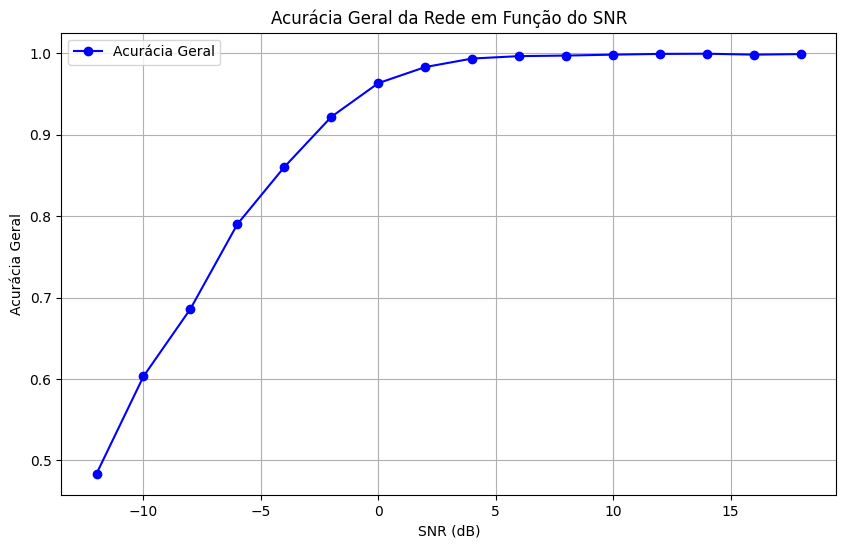

In [14]:
# Extração do SNR e a classe dos sinais
snr_values = np.arange(-12, 20, 2)
num_snr = len(snr_values)
num_modulations = len(desired_vals)

# Lista de nomes das modulações
modulation_names = [
"LFM", "FM_Costas", "2PSK", "PM_Barker", "PM_Frank", "PM_P1", "PM_P2", "PM_P3", "PM_P4", "Sem Modulação", "Ruído"
]

line_styles = ['-', '--', '-.', ':'] * 6
colors = plt.cm.get_cmap('tab20', num_modulations)

# Inicializar matriz para acurácia por modulação e lista para acurácia geral
accuracy_per_modulation = np.zeros((num_modulations, num_snr))
overall_accuracy = []

# Processar cada modulação para calcular a acurácia por faixa de SNR
for mod_idx in range(num_modulations):
    modulation_indices = np.where(new_Y_test[:, mod_idx] == 1)[0]
    x_modulation = new_X_test[modulation_indices]
    y_modulation = new_Y_test[modulation_indices]
    z_modulation = new_lbl_test[modulation_indices, 1]  # SNR está na segunda coluna de lbl_data

    for snr_idx, snr in enumerate(snr_values):
        snr_indices = np.where(z_modulation == snr)[0]
        x_snr = x_modulation[snr_indices]
        y_snr = y_modulation[snr_indices]
        
        if len(x_snr) == 0:
            accuracy_per_modulation[mod_idx, snr_idx] = np.nan
            continue
        
        # Fazer predições com o modelo
        predictions_snr = model.predict(x_snr)
        
        # Calcular a acurácia
        accuracy = np.mean(np.argmax(predictions_snr, axis=1) == np.argmax(y_snr, axis=1))
        accuracy_per_modulation[mod_idx, snr_idx] = accuracy

# Calcular a acurácia geral para cada faixa de SNR
for snr in snr_values:
    snr_indices = np.where(new_lbl_test[:, 1] == snr)[0]  # SNR está na segunda coluna de lbl_data
    x_snr = new_X_test[snr_indices]
    y_snr = new_Y_test[snr_indices]

    if len(x_snr) == 0:
        overall_accuracy.append(np.nan)
        continue

    # Fazer predições com o modelo
    predictions_snr = model.predict(x_snr)

    # Calcular a acurácia geral
    accuracy = np.mean(np.argmax(predictions_snr, axis=1) == np.argmax(y_snr, axis=1))
    overall_accuracy.append(accuracy)

# Converter para array numpy para facilitar o plot
overall_accuracy = np.array(overall_accuracy)

# Plotar a acurácia por modulação
plt.figure(figsize=(14, 8))
for mod_idx in range(num_modulations):
    plt.plot(
        snr_values,
        accuracy_per_modulation[mod_idx],
        label=modulation_names[mod_idx],
        linestyle=line_styles[mod_idx % len(line_styles)],
        color=colors(mod_idx)
    )

plt.xlabel("SNR (dB)")
plt.ylabel("Acurácia")
plt.title("Acurácia de Cada Modulação em Função do SNR")
plt.legend(loc="best")
plt.grid(True)
plt.show()

# Plotar a acurácia geral
plt.figure(figsize=(10, 6))
plt.plot(snr_values, overall_accuracy, marker='o', linestyle='-', color='b', label='Acurácia Geral')

plt.xlabel("SNR (dB)")
plt.ylabel("Acurácia Geral")
plt.title("Acurácia Geral da Rede em Função do SNR")
plt.grid(True)
plt.legend()
plt.show()


In [12]:
# Diretório de logs para o profiler
log_dir = "logs/profiler_inference"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)

# Medir o tempo de inferência
start_time = time.time()

# Realiza predições
predictions = model.predict(new_X_test)

# Medir o tempo de inferência
end_time = time.time()
inference_time = end_time - start_time

# Imprimir tempo de inferência
print(f"Tempo de inferência: {inference_time:.4f} segundos")

2338/2338 [==============================] - 196s 84ms/step
Tempo de inferência: 198.4661 segundos



Relatório de Classificação:
               precision    recall  f1-score   support

          LFM       0.99      0.99      0.99      6800
    FM_Costas       0.89      0.90      0.90      6800
         2PSK       0.98      0.96      0.97      6800
    PM_Barker       0.90      0.87      0.89      6800
     PM_Frank       0.83      0.86      0.84      6800
        PM_P1       0.83      0.82      0.82      6800
        PM_P2       0.83      0.84      0.83      6800
        PM_P3       0.82      0.85      0.84      6800
        PM_P4       0.88      0.82      0.85      6800
Sem Modulação       0.99      0.99      0.99      6800
        Ruído       0.96      0.99      0.97      6800

     accuracy                           0.90     74800
    macro avg       0.90      0.90      0.90     74800
 weighted avg       0.90      0.90      0.90     74800



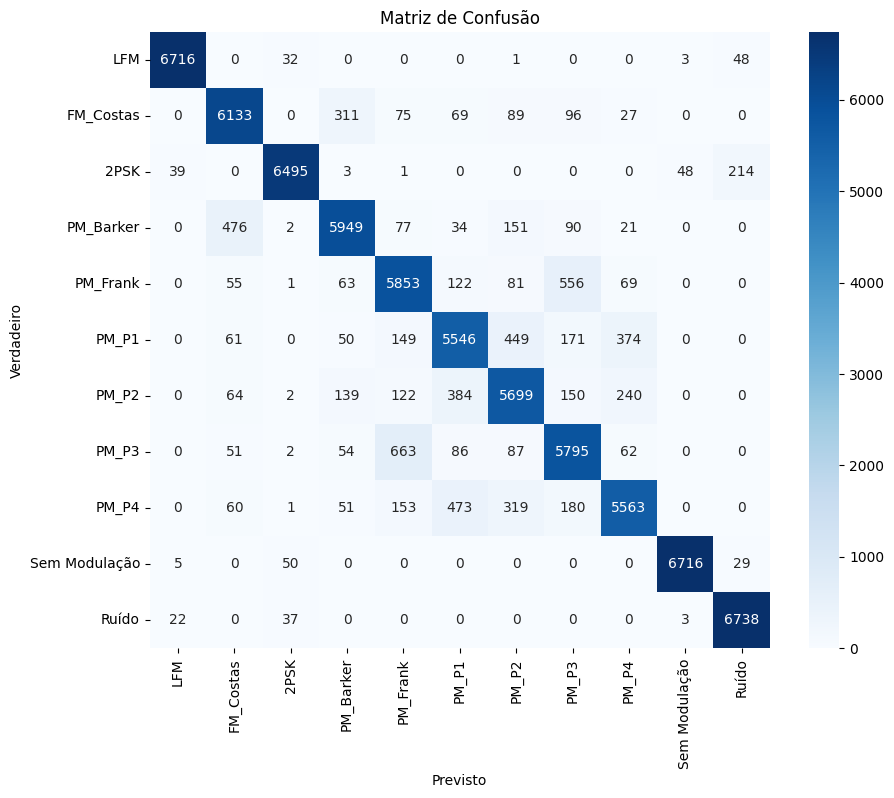

In [13]:
# Predição utilizando melhor modelo obtido
y_pred = np.argmax(predictions, axis=1)

# Conversão do formato one hot para categórico
if len(new_Y_test.shape) > 1 and new_Y_test.shape[1] > 1:
    new_Y_test = np.argmax(new_Y_test, axis=1)

# Relatório de classificação
print("\nRelatório de Classificação:")
print(classification_report(new_Y_test, y_pred, target_names=modulation_names))

# Matriz de confusão
conf_matrix = confusion_matrix(new_Y_test, y_pred)

# Visualização da matriz de confusão
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=modulation_names, 
            yticklabels=modulation_names)
plt.xlabel("Previsto")
plt.ylabel("Verdadeiro")
plt.title("Matriz de Confusão")
plt.show()